In [1]:
import pandas as pd
import datetime
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.stats.api as sms



# Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [2]:
auth = pd.read_csv('problem1-auth_data.csv', sep=';')

In [3]:
reg = pd.read_csv('problem1-reg_data.csv', sep=';')

In [4]:
df = reg.merge(auth, on='uid')
df = df[['uid', 'reg_ts', 'auth_ts']]

In [5]:
df['reg_ts'] = pd.to_datetime(df['reg_ts'], unit='s')
df['auth_ts'] = pd.to_datetime(df['auth_ts'], unit='s')
df.head()

,uid,reg_ts,auth_ts
0,1,1998-11-18 09:43:43,1998-11-18 09:43:43
1,2,1999-07-22 22:38:09,1999-07-22 22:38:09
2,2,1999-07-22 22:38:09,1999-07-25 16:46:46
3,2,1999-07-22 22:38:09,1999-07-31 03:50:15
4,2,1999-07-22 22:38:09,1999-08-05 17:49:39


In [6]:
df['cohort'] = df['reg_ts'].dt.to_period('d').astype(str) #cohorts by signup date

In [7]:
#function for calculating n-day retention:
def n_day_ret(n, data): 
    n,
    data,
    retained = []    
    data = data.drop_duplicates().reset_index(drop=True)
    data['reg_ts'] = data['reg_ts'].dt.to_period('d')
    data['auth_ts'] = data['auth_ts'].dt.to_period('d')
    for i in range(data.shape[0]):
        if data.auth_ts[i] == (data.reg_ts[i] + datetime.timedelta(n)) and data.uid[i] not in retained:
            retained.append(data.uid[i])

    return(print(n, '- day retention is', (len(retained) / data.uid.nunique()) * 100, '%'))

In [8]:
data = df.query('cohort == "2019-01-01"') # checking on sample
n_day_ret(10, data)

10 - day retention is 6.003430531732419 %


***


## Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

## Pешение
Для оценки результатов эксперимента проанализируем ARPPU и сравним долю платящих пользователей в обеих группах. Для начала исследуем данные:

In [9]:
abtest = pd.read_csv('https://stepik.org/media/attachments/lesson/409318/problem2.csv', sep=';')

In [10]:
abtest.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [11]:
abtest['paying'] = abtest.revenue.apply(lambda x:  1 if x > 0 else 0)

In [12]:
abtest.query('testgroup == "a"').sort_values('revenue')

,user_id,revenue,testgroup,paying
1,2,0,a,0
269294,269295,0,a,0
269295,269296,0,a,0
269299,269300,0,a,0
269300,269301,0,a,0
...,...,...,...,...
142804,142805,37379,a,1
21585,21586,37385,a,1
65077,65078,37394,a,1
196601,196602,37407,a,1


In [13]:
a = abtest.query('testgroup == "a"')
b = abtest.query('testgroup == "b"')

Посмотрим, как распредилились доходы с пользователя:

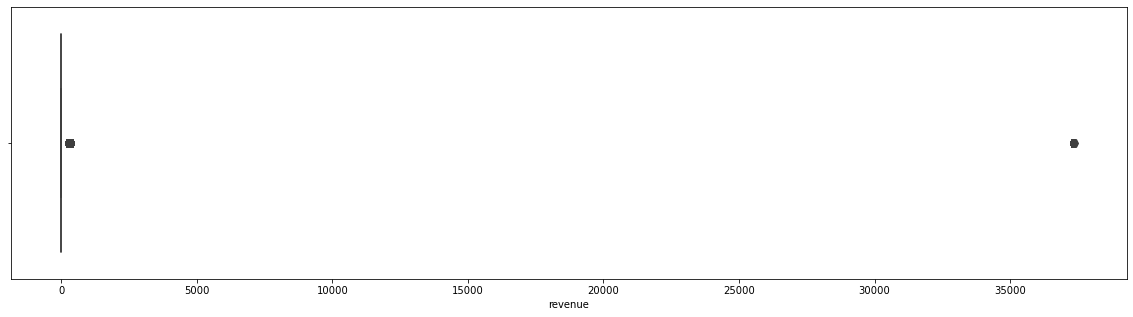

In [14]:
#check for outliers:
plt.figure(figsize=(20, 5))
sns.boxplot(a.revenue)

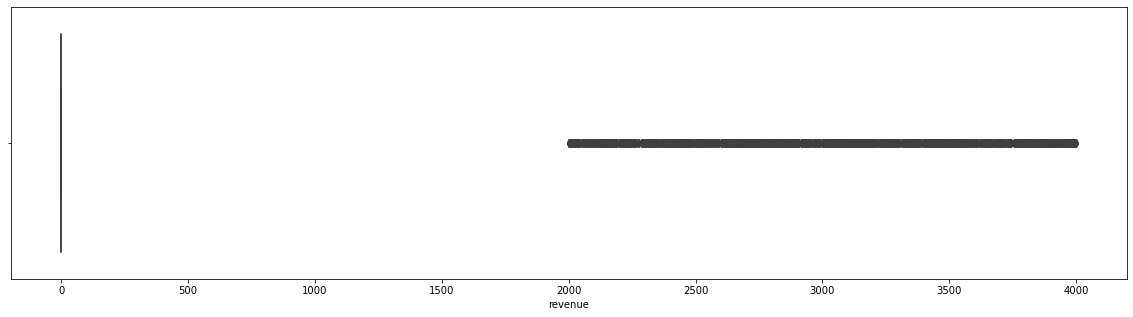

In [15]:
#check for outliers:
plt.figure(figsize=(20, 5))
sns.boxplot(b.revenue)


В контрольной группе платящие пользователи разделились на две группы, одна из которых приносит очень большую прибыль. Рассмотрим данные о платящих пользователях более пристально и определим, является ли эта группа выбросом:

In [16]:
#Платащие control
paying_a = abtest.query('testgroup == "a" & paying == 1')
paying_a.revenue.mean()

2663.9984439834025

In [17]:
#определим выбросы при помощи межквартильного размаха
a_lower = np.quantile(paying_a.revenue, 0.25) - 1.5 * stats.iqr(paying_a.revenue)
a_lower

101.0

In [18]:
a_upper = np.quantile(paying_a.revenue, 0.75) + 1.5 * stats.iqr(paying_a.revenue)
a_upper

517.0

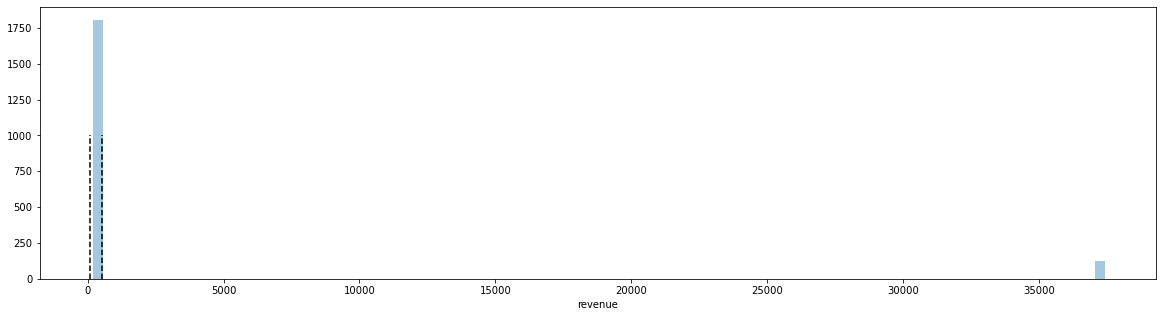

In [19]:
plt.figure(figsize=(20, 5))
plt.vlines([a_lower, a_upper], ymin=0, ymax=1000, linestyle='--')
sns.distplot(paying_a.revenue, kde=False, bins=100)

Данные выходят за грани 'усов' боксплота, а значит их можно считать выбросами. Найдем их:

In [20]:
outliers = paying_a.query('revenue > 517').sort_values('revenue')
outliers

,user_id,revenue,testgroup,paying
19495,19496,37293,a,1
81477,81478,37294,a,1
235858,235859,37294,a,1
254113,254114,37294,a,1
34534,34535,37294,a,1
...,...,...,...,...
142804,142805,37379,a,1
21585,21586,37385,a,1
65077,65078,37394,a,1
196601,196602,37407,a,1


Таким образом, в группе A имеются 123 клиента, суммы покупок которых значительно выше медианных (37293 - 37433) и могут считаться выбросами.

In [21]:
# Платящие test
paying_b = abtest.query('testgroup == "b" & paying == 1')
paying_b.revenue.mean()

3003.6581717451522

In [22]:
b1 = np.quantile(paying_b.revenue, 0.25) - 1.5 * stats.iqr(paying_b.revenue)
b1

1065.5

In [23]:
b2 = np.quantile(paying_b.revenue, 0.75) + 1.5 * stats.iqr(paying_b.revenue)
b2

4925.5

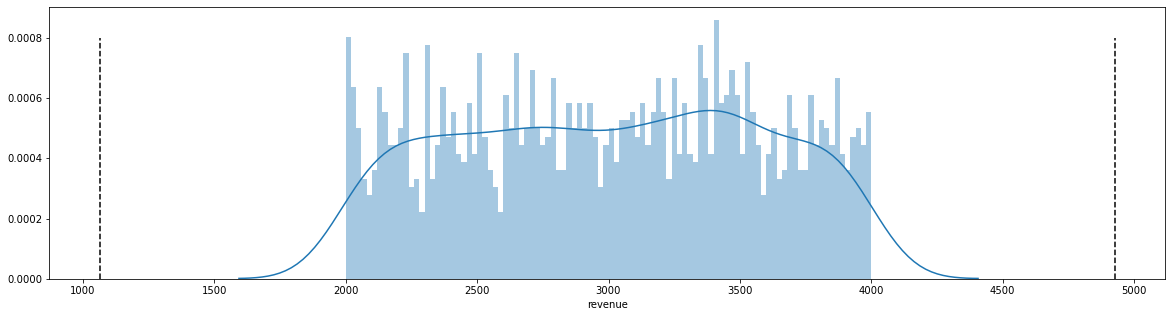

In [24]:
plt.figure(figsize=(20, 5))
plt.vlines([b1, b2], ymin=0, ymax=0.0008, linestyle='--')
sns.distplot(paying_b.revenue, bins=100)

В тестовой группе выбросов нет.  Прежде чем применить Т-тест, необходимо найти выбросы в контрольной группе и исключить их из выборки.

In [25]:
abtest_no_outliers = abtest.loc[((abtest['testgroup']=='a') & (abtest['revenue']<=517)) | (abtest['testgroup']=='b')]

In [26]:
paying_a_cleaned = abtest_no_outliers.query('testgroup == "a"')

In [27]:
abtest.shape[0] - abtest_no_outliers.shape[0]

123

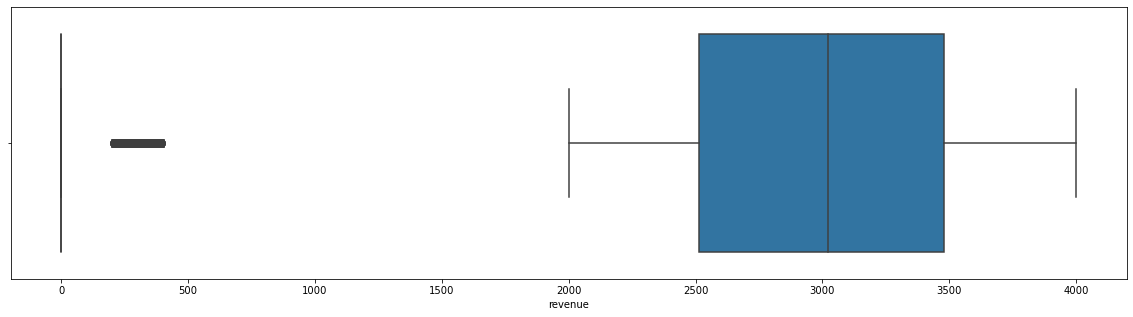

In [28]:
plt.figure(figsize=(20,5))
sns.boxplot(paying_a_cleaned.revenue)
sns.boxplot(paying_b.revenue)

Как видно на графике выше, теперь в обеих группах выбросы отсутствуют

Проверим, как соотносятся ARPPU после исключения выбросов:

In [29]:
paying_b.revenue.mean()

3003.6581717451522

In [30]:
paying_a_cleaned.revenue.mean()

2.702926032280424

In [31]:
ARPPU_diff = paying_b.revenue.mean() / paying_a_cleaned.revenue.mean() * 100 - 100
if ARPPU_diff > 0:
    print('ARPPU(B) > ARPPU(A) by', round(abs(ARPPU_diff), 2), '%')
elif diff2 < 0:
    print('ARPPU(B) < ARPPU(A) by', round(abs(ARPPU_diff), 2), '%')
else:
    print('ARPPU(A) = ARPPU(B)')

ARPPU(B) > ARPPU(A) by 111026.17 %


In [32]:
t2 = stats.ttest_ind(paying_a_cleaned.revenue, paying_b.revenue)[1]
if t2 < 0.05:
    print('Reject H0,', 'p-value =', t2)
else:
    print('Accept H0', 'p-value =', t2)

Reject H0, p-value = 0.0


Таким образом, ARPPU тестовой группы выше контрольной на 893% (p-value = 0).

***


Теперь проверим, есть ли значимые различия между долями платящих пользователей в группах. Применим хи-квадрат Пирсона для анализа таблицы сопряженности:

In [33]:
ttt = pd.crosstab(abtest_no_outliers['testgroup'], abtest_no_outliers['paying'])
ttt

paying,0,1
testgroup,,
a,200175,1805
b,200862,1805


In [34]:
table = ttt
if stats.chi2_contingency(table)[1] > 0.05:
    print('Accept H0, p =', stats.chi2_contingency(table)[1])
else:
    print('Reject H0, p =', stats.chi2_contingency(table)[1])

Accept H0, p = 0.9316668591658103


In [35]:
print('Paying share control:',
      abtest_no_outliers \
          .query('testgroup == "a" & paying == 1') \
          .revenue \
          .count() 
      / abtest_no_outliers \
          .query('testgroup == "a"') \
          .revenue \
          .count() * 100, '%')

Paying share control: 0.893652836914546 %


In [36]:
print('Paying share test:',
      abtest_no_outliers \
          .query('testgroup == "b" & paying == 1') \
          .revenue \
          .count() 
      / abtest_no_outliers \
          .query('testgroup == "b"') \
          .revenue \
          .count() * 100, '%')

Paying share test: 0.8906235351586593 %


Доля платящих пользователей в обеих группах составила 0.89%. Существенных различий между группами не было выявлено.

***



Рассчитаем ARPU после исключения выбросов из контрольной группы:

In [37]:
ARPU_diff = abtest_no_outliers.query('testgroup == "b"').revenue.mean() / abtest_no_outliers.query('testgroup == "a"').revenue.mean() * 100 - 100
if ARPPU_diff > 0:
    print('ARPU(B) > ARPU(A) by', round(abs(ARPU_diff), 2), '%')
elif diff2 < 0:
    print('ARPU(B) < ARPU(A) by', round(abs(ARPU_diff), 2), '%')
else:
    print('ARPU(A) = ARPU(B)')

ARPU(B) > ARPU(A) by 889.72 %


In [38]:
# Используем Т-тест для сравнения средних:
stats.ttest_ind(abtest_no_outliers.query("testgroup == 'a'").revenue,
               abtest_no_outliers.query("testgroup == 'b'").revenue)

Ttest_indResult(statistic=-37.42623596967759, pvalue=4.912187544972622e-306)

ARPU(test) > ARPU(control) на 889.72 %, различия стат.значимы (p-value < 0.05)

In [39]:
abtest_no_outliers.query('testgroup == "a"').revenue.mean() # ARPU Group A

2.702926032280424

In [40]:
abtest_no_outliers.query('testgroup == "b"').revenue.mean() # ARPU Group B

26.75128659327863

## Summary:

Предложение группы B можно считать лучшим.

После исключения выбросов ARPPU(B) > ARPPU(A) на 893%, различия статистически значимы (p-value < 0.05).

ARPU(B) > ARPU(A) на 889.72 %, различия стат.значимы (p-value < 0.05).

Доля платящих пользователей в обоих случаях составила 0.89%, стат. значимых различий между группами не выявлено.

Следует более детально изучить природу выбросов:

- это могли быть т.н. 'киты', которые действительно совершают крупные покупки; 

- возможна ошибка в логировании данных. Необходимо более детально изучить данные о пользователях, транзакциях и убедиться, что данные отображены корректно и система логирования работает верно.

***